In [1]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='15cfd96b0bdfd1b0c67597c24f91907776c02a6d', drake_version='0.27.0', drake_build='release')

server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']
# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc_planar, zmq_url_planar, web_url_planar = start_zmq_server_as_subprocess(server_args=server_args)
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

import numpy as np
from ipywidgets import FloatSlider, ToggleButton
from IPython.display import display, SVG, HTML
import pydot
import matplotlib.pyplot as plt

import pydrake.all
from pydrake.all import (
    MultibodyPlant, DiagramBuilder, LinearQuadraticRegulator, Saturation, SceneGraph, Simulator, 
    WrapToSystem, AddMultibodyPlantSceneGraph, Parser, MathematicalProgram, eq, PiecewisePolynomial,
    SnoptSolver, TrajectorySource, MultibodyPositionToGeometryPose, PlanarSceneGraphVisualizer
)
from pydrake.examples.acrobot import AcrobotPlant, AcrobotGeometry
from pydrake.systems.jupyter_widgets import WidgetSystem
from pydrake.common.containers import namedview
from underactuated import FindResource, ManipulatorDynamics
from underactuated.jupyter import running_as_notebook


Cloning into '/opt/underactuated'...

HEAD is now at 15cfd96 and again

ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
ERROR: bokeh 2.3.2 has requirement pillow>=7.1.0, but you'll have pillow 7.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.






# Various Optimization Setups

In [2]:
def generate_cont_vars(prog, nq, T):
  """ Returns h, q, qd, qdd, u """
  # vector of the time intervals
  # (distances between the T + 1 break points)
  h = prog.NewContinuousVariables(T, name='h')

  # system configuration, generalized velocities, and accelerations
  q = prog.NewContinuousVariables(rows=T+1, cols=nq, name='q')
  qd = prog.NewContinuousVariables(rows=T+1, cols=nq, name='qd')
  qdd = prog.NewContinuousVariables(rows=T, cols=nq, name='qdd')

  # actuation
  u = prog.NewContinuousVariables(rows=T, cols=nq, name='u')

  return h, q, qd, qdd, u

#startend[0,:] =[q0_start, q0_end]
#starend[1,:] = [q1_start, q1_end]
def set_initial_guess(prog, h_max, T, h, q, qd, qdd, q_start_end):
  # vector of the initial guess
  initial_guess = np.empty(prog.num_vars())
  # initial guess for the time step
  h_guess = h_max
  prog.SetDecisionVariableValueInVector(h, [h_guess] * T, initial_guess)

  # linear interpolation of the configuration
  q0_guess = np.array([0, 1])
  q_guess_poly = PiecewisePolynomial.FirstOrderHold(
      [0, T * h_guess],
      q_start_end
  )

  qd_guess_poly = q_guess_poly.derivative()
  qdd_guess_poly = qd_guess_poly.derivative()

  # set initial guess for configuration, velocity, and acceleration
  q_guess = np.hstack([q_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
  qd_guess = np.hstack([qd_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
  qdd_guess = np.hstack([qdd_guess_poly.value(t * h_guess) for t in range(T)]).T
  prog.SetDecisionVariableValueInVector(q, q_guess, initial_guess)
  prog.SetDecisionVariableValueInVector(qd, qd_guess, initial_guess)
  
  prog.SetDecisionVariableValueInVector(qdd, qdd_guess, initial_guess)

  return initial_guess

def simulate(result, h, q, qd, qdd, u, ballbot_urdf):
  # get optimal solution
  h_opt = result.GetSolution(h)
  q_opt = result.GetSolution(q)
  qd_opt = result.GetSolution(qd)
  qdd_opt = result.GetSolution(qdd)

  # stack states
  x_opt = np.hstack((q_opt, qd_opt))

  # interpolate state values for animation
  time_breaks_opt = np.array([sum(h_opt[:t]) for t in range(T+1)])
  x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_opt.T)

  # parse urdf with scene graph
  ballbot = MultibodyPlant(time_step=0)
  scene_graph = SceneGraph()
  ballbot.RegisterAsSourceForSceneGraph(scene_graph)
  Parser(ballbot).AddModelFromString(ballbot_urdf, "urdf")
  ballbot.Finalize()

  # build block diagram and drive system state with
  # the trajectory from the optimization problem
  builder = DiagramBuilder()
  source = builder.AddSystem(TrajectorySource(x_opt_poly))
  builder.AddSystem(scene_graph)
  pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(ballbot, input_multibody_state=True))
  builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
  builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(ballbot.get_source_id()))
  
  # add visualizer
  xlim = [-2, 2]
  ylim = [-.4, 1.5]
  visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False))
  builder.Connect(scene_graph.get_pose_bundle_output_port(), visualizer.get_input_port(0))
  simulator = Simulator(builder.Build())

  # generate and display animation
  visualizer.start_recording()
  simulator.AdvanceTo(x_opt_poly.end_time())
  ani = visualizer.get_recording_as_animation()
  return ani

## No Cost, Just Get There

In [20]:
def no_cost(T, h_min, h_max, goal, start, actuation_lim, tilt_lim, ballbot_urdf):
  # parse urdf and create the MultibodyPlant
  ballbot_2D = MultibodyPlant(time_step=0)
  Parser(ballbot_2D).AddModelFromString(ballbot_urdf, "urdf")
  ballbot_2D.Finalize()

  # overwrite MultibodyPlant with its autodiff copy
  ballbot_2D = ballbot_2D.ToAutoDiffXd() 

  # number of configuration variables
  nq = ballbot_2D.num_positions()  # Returns the size of the multibody system state vector x = [q v]. This will be num_positions() plus num_velocities()

  def ballbot2D_dynamics(vars):
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, u = np.split(vars, split_at)
    context = ballbot_2D.CreateDefaultContext()
    ballbot_2D.SetPositions(context, q)
    ballbot_2D.SetVelocities(context, qd)
    ballbot_2D.get_actuation_input_port().FixValue(context, u)
    M, Cv, tauG, B, tauExt = ManipulatorDynamics(ballbot_2D,q,qd)
    theta = q[1]
    return M.dot(qdd) + Cv - tauG - B@u - tauExt

  # initialize program
  prog = MathematicalProgram()
  h, q, qd, qdd, u = generate_cont_vars(prog, nq, T)

  # 1. lower and upper bound on the time steps for all t
  prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

  # 2. link the configurations, velocities, and accelerations
  # uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
  for t in range(T):
      prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
      prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

  # 3. drake dynamics
  for t in range(T):
    vars = np.concatenate((q[t], qd[t], qdd[t], u[t]))
    prog.AddConstraint(ballbot2D_dynamics, lb=[0]*nq, ub=[0]*nq, vars=vars)
    prog.AddLinearConstraint(u[t][0] == u[t][1])  

  # 4. goal at end
  prog.AddLinearConstraint(q[-1][0] == goal[0])
  prog.AddLinearConstraint(q[-1][1] == goal[1])
  prog.AddLinearConstraint(qd[-1][0] == goal[2])
  prog.AddLinearConstraint(qd[-1][1] == goal[3])

  # give start position
  prog.AddLinearConstraint(q[0][0] == start[0])
  prog.AddLinearConstraint(q[0][1] == start[1])
  prog.AddLinearConstraint(qd[0][0] == start[2])
  prog.AddLinearConstraint(qd[0][1] == start[3])

  # 5. Tilt Angle Constraint
  if tilt_lim is not None:
    for t in range(T):
      prog.AddLinearConstraint(q[t][1] <= tilt_lim)
      prog.AddLinearConstraint(q[t][1] >= -1* tilt_lim)

  #startend[0,:] =[q0_start, q0_end]
  #starend[1,:] = [q1_start, q1_end]
  initial_guess = set_initial_guess(prog, h_max, T, h, q, qd, qdd, np.array([[start[0], goal[0]], [start[1], goal[1]]]))

  # 6. actuation constraint
  if actuation_lim is not None:
    for t in range(T):
      prog.AddLinearConstraint(u[t][0] <= actuation_lim)
      prog.AddLinearConstraint(u[t][0] >= -1* actuation_lim)

  # solve mathematical program with initial guess
  solver = SnoptSolver()
  result = solver.Solve(prog, initial_guess)
  print(f'Solution found? {result.is_success()}.')

  return result, h, q, qd, qdd, u

## Add Time/Distance Cost

In [21]:
def distance_cost(T, h_min, h_max, goal, start, actuation_lim, tilt_lim, ballbot_urdf):
  # parse urdf and create the MultibodyPlant
  ballbot_2D = MultibodyPlant(time_step=0)
  Parser(ballbot_2D).AddModelFromString(ballbot_urdf, "urdf")
  ballbot_2D.Finalize()

  # overwrite MultibodyPlant with its autodiff copy
  ballbot_2D = ballbot_2D.ToAutoDiffXd() 

  # number of configuration variables
  nq = ballbot_2D.num_positions()  # Returns the size of the multibody system state vector x = [q v]. This will be num_positions() plus num_velocities()

  def ballbot2D_dynamics(vars):
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, u = np.split(vars, split_at)
    context = ballbot_2D.CreateDefaultContext()
    ballbot_2D.SetPositions(context, q)
    ballbot_2D.SetVelocities(context, qd)
    ballbot_2D.get_actuation_input_port().FixValue(context, u)
    M, Cv, tauG, B, tauExt = ManipulatorDynamics(ballbot_2D,q,qd)
    theta = q[1]
    return M.dot(qdd) + Cv - tauG -B@u - tauExt

  # initialize program
  prog = MathematicalProgram()
  h, q, qd, qdd, u = generate_cont_vars(prog, nq, T)

  # 1. lower and upper bound on the time steps for all t
  prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

  # 2. link the configurations, velocities, and accelerations
  # uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
  for t in range(T):
      prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
      prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

  # 3. drake dynamics
  for t in range(T):
    vars = np.concatenate((q[t], qd[t], qdd[t], u[t]))
    prog.AddConstraint(ballbot2D_dynamics, lb=[0]*nq, ub=[0]*nq, vars=vars)
    prog.AddLinearConstraint(u[t][0] == u[t][1])

  # 4. Penalize time away from goal
  total = 0
  for t in range(T):
    total += (q[t][1]**2)**0.5
    total += (q[t][0]**2)**0.5
  prog.AddCost(total)  

  # 5. goal at end
  prog.AddLinearConstraint(q[-1][0] == goal[0])
  prog.AddLinearConstraint(q[-1][1] == goal[1])
  prog.AddLinearConstraint(qd[-1][0] == goal[2])
  prog.AddLinearConstraint(qd[-1][1] == goal[3])

  # give start position
  prog.AddLinearConstraint(q[0][0] == start[0])
  prog.AddLinearConstraint(q[0][1] == start[1])
  prog.AddLinearConstraint(qd[0][0] == start[2])
  prog.AddLinearConstraint(qd[0][1] == start[3])

  # 6. Tilt Angle Constraint
  if tilt_lim is not None:
    for t in range(T):
      prog.AddLinearConstraint(q[t][1] <= tilt_lim)
      prog.AddLinearConstraint(q[t][1] >= -1* tilt_lim)

  # 7. actuation constraint
  if actuation_lim is not None:
    for t in range(T):
      prog.AddLinearConstraint(u[t][0] <= actuation_lim)
      prog.AddLinearConstraint(u[t][0] >= -1* actuation_lim)

  initial_guess = set_initial_guess(prog, h_max, T, h, q, qd, qdd, np.array([[start[0], goal[0]], [start[1], goal[1]]]))

  # solve mathematical program with initial guess
  solver = SnoptSolver()
  result = solver.Solve(prog, initial_guess)
  print(f'Solution found? {result.is_success()}.')

  return result, h, q, qd, qdd, u 

In [22]:
def quadratic_distance_cost(T, h_min, h_max, goal, start, actuation_lim, tilt_lim, ballbot_urdf):
  # parse urdf and create the MultibodyPlant
  ballbot_2D = MultibodyPlant(time_step=0)
  Parser(ballbot_2D).AddModelFromString(ballbot_urdf, "urdf")
  ballbot_2D.Finalize()

  # overwrite MultibodyPlant with its autodiff copy
  ballbot_2D = ballbot_2D.ToAutoDiffXd() 

  # number of configuration variables
  nq = ballbot_2D.num_positions()  # Returns the size of the multibody system state vector x = [q v]. This will be num_positions() plus num_velocities()

  # number of components of the contact forces
  nf = 2

  def ballbot2D_dynamics(vars):
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, u = np.split(vars, split_at)
    context = ballbot_2D.CreateDefaultContext()
    ballbot_2D.SetPositions(context, q)
    ballbot_2D.SetVelocities(context, qd)
    ballbot_2D.get_actuation_input_port().FixValue(context, u)
    M, Cv, tauG, B, tauExt = ManipulatorDynamics(ballbot_2D,q,qd)
    theta = q[1]
    return M.dot(qdd) + Cv - tauG -B@u - tauExt

  # initialize program
  prog = MathematicalProgram()
  h, q, qd, qdd, u = generate_cont_vars(prog, nq, T)

  # 1. lower and upper bound on the time steps for all t
  prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

  # 2. link the configurations, velocities, and accelerations
  # uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
  for t in range(T):
      prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
      prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

  # 3. drake dynamics
  for t in range(T):
    vars = np.concatenate((q[t], qd[t], qdd[t], u[t]))
    prog.AddConstraint(ballbot2D_dynamics, lb=[0]*nq, ub=[0]*nq, vars=vars)
    prog.AddLinearConstraint(u[t][0] == u[t][1])

  # 4. Penalize time away from goal
  total = 0
  for t in range(T):
    total += q[t][1]**2
    total += q[t][0]**2
  prog.AddCost(total)  

  # 5. goal at end
  prog.AddLinearConstraint(q[-1][0] == goal[0])
  prog.AddLinearConstraint(q[-1][1] == goal[1])
  prog.AddLinearConstraint(qd[-1][0] == goal[2])
  prog.AddLinearConstraint(qd[-1][1] == goal[3])

  # give start position
  prog.AddLinearConstraint(q[0][0] == start[0])
  prog.AddLinearConstraint(q[0][1] == start[1])
  prog.AddLinearConstraint(qd[0][0] == start[2])
  prog.AddLinearConstraint(qd[0][1] == start[3])

  # 6. Tilt Angle Constraint
  if tilt_lim is not None:
    for t in range(T):
      prog.AddLinearConstraint(q[t][1] <= tilt_lim)
      prog.AddLinearConstraint(q[t][1] >= -1* tilt_lim)

  # 7. actuation constraint
  if actuation_lim is not None:
    for t in range(T):
      prog.AddLinearConstraint(u[t][0] <= actuation_lim)
      prog.AddLinearConstraint(u[t][0] >= -1* actuation_lim)

  initial_guess = set_initial_guess(prog, h_max, T, h, q, qd, qdd, np.array([[start[0], goal[0]], [start[1], goal[1]]]))

  # solve mathematical program with initial guess
  solver = SnoptSolver()
  result = solver.Solve(prog, initial_guess)
  print(f'Solution found? {result.is_success()}.')

  return result, h, q, qd, qdd, u 

## LQR Cost

In [3]:
def lqr_cost(total_time, h_min, h_max, goal, start, actuation_lim, tilt_lim, ballbot_urdf):
  avg_h = (h_min+h_max)/2
  T = int(total_time/avg_h)

  # parse urdf and create the MultibodyPlant
  ballbot_2D = MultibodyPlant(time_step=0)
  Parser(ballbot_2D).AddModelFromString(ballbot_urdf, "urdf")
  ballbot_2D.Finalize()

  # overwrite MultibodyPlant with its autodiff copy
  ballbot_2D = ballbot_2D.ToAutoDiffXd() 

  # number of configuration variables
  nq = ballbot_2D.num_positions()  # Returns the size of the multibody system state vector x = [q v]. This will be num_positions() plus num_velocities()

  # number of components of the contact forces
  nf = 2

  def ballbot2D_dynamics(vars):
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, u = np.split(vars, split_at)
    context = ballbot_2D.CreateDefaultContext()
    ballbot_2D.SetPositions(context, q)
    ballbot_2D.SetVelocities(context, qd)
    ballbot_2D.get_actuation_input_port().FixValue(context, u)
    M, Cv, tauG, B, tauExt = ManipulatorDynamics(ballbot_2D,q,qd)
    theta = q[1]
    return M.dot(qdd) + Cv - tauG -B@u - tauExt

  # initialize program
  prog = MathematicalProgram()
  h, q, qd, qdd, u = generate_cont_vars(prog, nq, T)

  # 1. lower and upper bound on the time steps for all t
  prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h)

  # 2. link the configurations, velocities, and accelerations
  # uses implicit Euler method, https://en.wikipedia.org/wiki/Backward_Euler_method
  for t in range(T):
      prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
      prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

  # 3. drake dynamics
  for t in range(T):
    vars = np.concatenate((q[t], qd[t], qdd[t], u[t]))
    prog.AddConstraint(ballbot2D_dynamics, lb=[0]*nq, ub=[0]*nq, vars=vars)
    prog.AddLinearConstraint(u[t][0] == u[t][1])

  # 4. Penalize distance away from goal
  total = 0
  for t in range(T+1):
    total += 10*(q[t][0] - goal[0])**2
    total += 10*(q[t][1] - goal[1])**2
  prog.AddCost(total)  

  # 5. Penalize velocity away from goal
  if len(goal) == 4:
    total = 0
    for t in range(T+1):
      total += (qd[t][0] - goal[2])**2
      total += (qd[t][1] - goal[3])**2
    prog.AddCost(total)  

  # 6. Penalize actuation squared
  total = 0
  for t in range(T):
    total += u[t][0]**2
  prog.AddCost(total)  

  # 7. goal at end
  prog.AddLinearConstraint(q[-1][0] == goal[0])
  prog.AddLinearConstraint(q[-1][1] == goal[1])
  prog.AddLinearConstraint(qd[-1][0] == goal[2])
  prog.AddLinearConstraint(qd[-1][1] == goal[3])

  # give start position
  prog.AddLinearConstraint(q[0][0] == start[0])
  prog.AddLinearConstraint(q[0][1] == start[1])
  prog.AddLinearConstraint(qd[0][0] == start[2])
  prog.AddLinearConstraint(qd[0][1] == start[3])

  # 8. Tilt Angle Constraint
  if tilt_lim is not None:
    for t in range(T):
      prog.AddLinearConstraint(q[t][1] <= tilt_lim)
      prog.AddLinearConstraint(q[t][1] >= -1* tilt_lim)

  # 9. actuation constraint
  if actuation_lim is not None:
    for t in range(T):
      prog.AddLinearConstraint(u[t][0] <= actuation_lim)
      prog.AddLinearConstraint(u[t][0] >= -1* actuation_lim)

  initial_guess = set_initial_guess(prog, h_max, T, h, q, qd, qdd, np.array([[start[0], goal[0]], [start[1], goal[1]]]))
  
  # solve mathematical program with initial guess
  solver = SnoptSolver()
  result = solver.Solve(prog, initial_guess)
  print(f'Solution found? {result.is_success()}.')

  return result, h, q, qd, qdd, u

# Gather Data For Paper

In [4]:
# total time
total_time = 10

# minimum and maximum time interval is seconds
h_min = .005
h_max = .2

# goal, start positions
goal = [0, 0, 0, 0]
start1 = [1,0,0,0]
start2 = [-1,np.pi/4,0,0]
start3= [-0.5, 1,0,0]

max_control = 1

In [18]:
def cost_breakdown(q, u, qd, goal, T, display=False, yscale="linear"):
  total_distance_from_target = 0
  total_actuation = 0
  goal_x = goal[0]

  distance_from_target = np.array([(q[t][0]**2 + goal_x**2)**0.5 for t in range(len(q))])
  distance_from_target_theta = np.array([(q[t][1]**2 + goal[1]**2)**0.5 for t in range(len(q))])
  actuation = np.array([u[t][0] for t in range(u.shape[0])] + [0])  # assuming u_x = u_theta since that's what Jorge said

  distance_squared = distance_from_target**2
  actuation_squared = actuation
  cost = 10*q[:,1]**2 + 10*q[:,0]**2 + actuation_squared + qd[:,1]**2 + qd[:,0]**2
  total_cost = np.sum(cost)

  if display:
    cost_sum = np.zeros(cost.shape)
    total = 0
    for i in range(cost.shape[0]):
      total += cost[i]
      cost_sum[i] = total

    time_steps = len(q)
    increment = T/time_steps
    times = [t*increment for t in range (len(q))]
    plt.plot(times, distance_from_target, label="Distance From Target")
    plt.plot(times, actuation, label="Actuation")
    plt.plot(times, cost, label="Cost")
    plt.plot(times, cost_sum, label="Total Cost")
    plt.yscale(yscale)
    plt.legend()
    plt.show()

  return distance_from_target, actuation, cost, total_cost

Solution found? True.


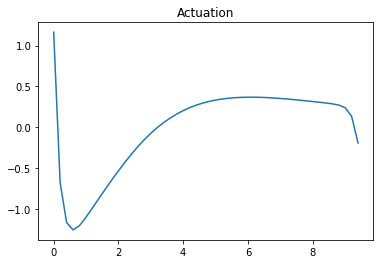

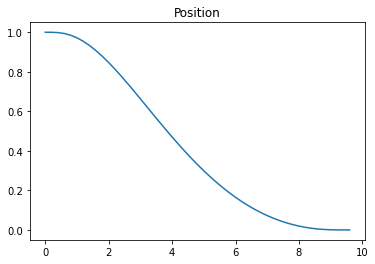

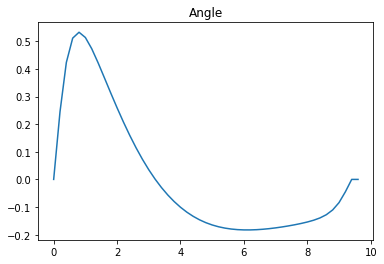

In [8]:
result, h, q, qd, qdd, u = lqr_cost(5, h_min, h_max, goal, start1, None, None, ballbot_standard)
h_opt = result.GetSolution(h)
q_opt = result.GetSolution(q)
qd_opt = result.GetSolution(qd)
qdd_opt = result.GetSolution(qdd)
u_opt = result.GetSolution(u)

plt.clf()
T = u.shape[0]
times = np.zeros(T)
for i in range(1, T):
  times[i] = times[i-1] + h_opt[i-1]
plt.plot(times, u_opt[:, 1])
plt.title("Actuation")
plt.show()

times = np.zeros(T+1)
for i in range(1, T+1):
  times[i] = times[i-1] + h_opt[i-1]
plt.plot(times, q_opt[:, 0])
plt.title("Position")
plt.show()

times = np.zeros(T+1)
for i in range(1, T+1):
  times[i] = times[i-1] + h_opt[i-1]
plt.plot(times, q_opt[:, 1])
plt.title("Angle")
plt.show()

HTML(simulate(result, h, q, qd, qdd, u, ballbot_standard).to_jshtml())

In [19]:
distance_from_target, actuation, cost, total_cost = cost_breakdown(q_opt, u_opt, qd_opt, goal, T, display=False, yscale="linear")
print(cost)

[11.16204373 11.41931734 11.39283791 11.43164963 11.35507806 10.99878354
 10.4082297   9.68666479  8.91629877  8.14690362  7.40568396  6.7066473
  6.0564008   5.45729635  4.90912742  4.41022341  3.95817431  3.55024837
  3.18358402  2.85524942  2.5622634   2.30163926  2.07046102  1.86596511
  1.6855939   1.52700478  1.3880403   1.26668147  1.16100898  1.06918828
  0.98947888  0.92025534  0.86002268  0.80741511  0.76118113  0.72016981
  0.6833335   0.64974164  0.61856599  0.5889731   0.55988564  0.52967326
  0.49594533  0.45548054  0.40354257  0.32957421  0.1976522  -0.14001845
  0.        ]


Solution found? True.


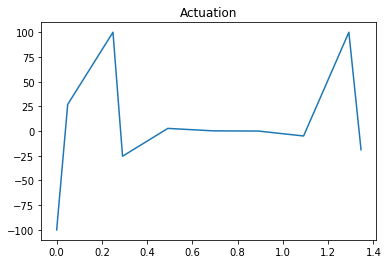

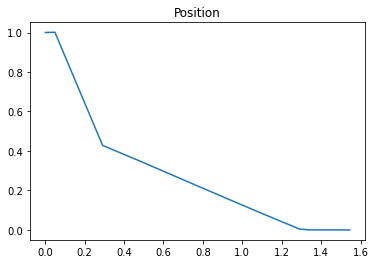

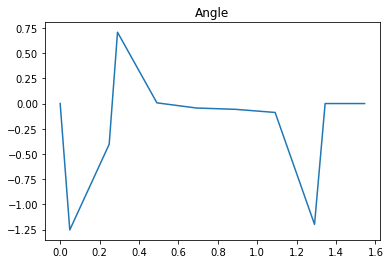

In [63]:
result, h, q, qd, qdd, u = quadratic_distance_cost(total_time, h_min, h_max, goal, start1, 100, None, ballbot_standard)
h_opt = result.GetSolution(h)
q_opt = result.GetSolution(q)
qd_opt = result.GetSolution(qd)
qdd_opt = result.GetSolution(qdd)
u_opt = result.GetSolution(u)

plt.clf()
T = u.shape[0]
times = np.zeros(T)
for i in range(1, T):
  times[i] = times[i-1] + h_opt[i-1]
plt.plot(times, u_opt[:, 1])
plt.title("Actuation")
plt.show()

times = np.zeros(T+1)
for i in range(1, T+1):
  times[i] = times[i-1] + h_opt[i-1]
plt.plot(times, q_opt[:, 0])
plt.title("Position")
plt.show()

times = np.zeros(T+1)
for i in range(1, T+1):
  times[i] = times[i-1] + h_opt[i-1]
plt.plot(times, q_opt[:, 1])
plt.title("Angle")
plt.show()

HTML(simulate(result, h, q, qd, qdd, u, ballbot_standard).to_jshtml())

In [56]:
simulate(result, h, q, qd, qdd, u, ballbot_standard).save("traj_opt_start1.mov")

Solution found? True.


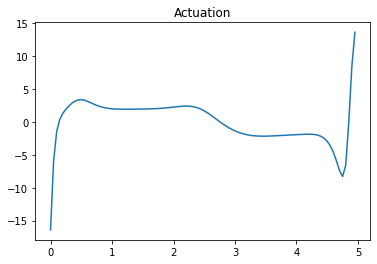

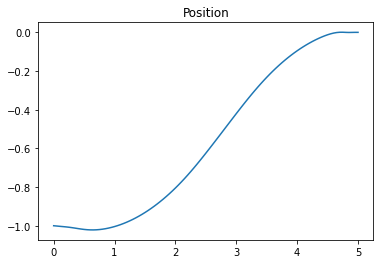

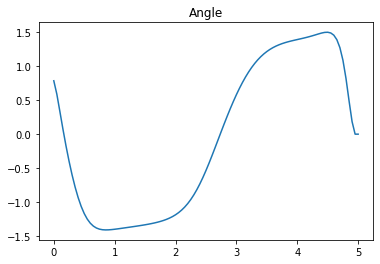

In [41]:
result, h, q, qd, qdd, u = lqr_cost(total_time, h_min, h_max, goal, start2, 100, None, ballbot_standard)
h_opt = result.GetSolution(h)
q_opt = result.GetSolution(q)
qd_opt = result.GetSolution(qd)
qdd_opt = result.GetSolution(qdd)
u_opt = result.GetSolution(u)

plt.clf()
times = np.zeros(T)
for i in range(1, T):
  times[i] = times[i-1] + h_opt[i-1]
plt.plot(times, u_opt[:, 1])
plt.title("Actuation")
plt.show()

times = np.zeros(T+1)
for i in range(1, T+1):
  times[i] = times[i-1] + h_opt[i-1]
plt.plot(times, q_opt[:, 0])
plt.title("Position")
plt.show()

times = np.zeros(T+1)
for i in range(1, T+1):
  times[i] = times[i-1] + h_opt[i-1]
plt.plot(times, q_opt[:, 1])
plt.title("Angle")
plt.show()

HTML(simulate(result, h, q, qd, qdd, u, ballbot_standard).to_jshtml())

Different URDFs, run before cells above to save variables locally 
(I just didn't want to cluter code above here)

In [7]:
ballbot_standard = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="5" />
      <inertia ixx=".2" ixy="0" ixz="0" iyy="0.2" iyz="0" izz="0.2" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.10" ixy="0" ixz="0" iyy="0.18" iyz="0" izz="0.1" />
    </inertial>
    <visual>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <joint name="x" type="prismatic">
    <parent link="world" />
    <child link="ball" />
    <origin xyz="0 0 .1" />
    <axis xyz="1 0 0" />
    <dynamics damping="0.1" />
  </joint>
   

  <joint name="theta1" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>


  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

  <transmission type="SimpleTransmission" name="ball_force">
    <actuator name="force" />
    <joint name="x" />
    <mechanicalReduction>.1</mechanicalReduction>
  </transmission>
</robot>
"""
#here the ball is 20% heavier and has 20% more moment of inertia
ballbot_heavyball = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="6" />
      <inertia ixx=".24" ixy="0" ixz="0" iyy="0.24" iyz="0" izz="0.24" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.10" ixy="0" ixz="0" iyy="0.18" iyz="0" izz="0.1" />
    </inertial>
    <visual>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <joint name="x" type="prismatic">
    <parent link="world" />
    <child link="ball" />
    <origin xyz="0 0 .1" />
    <axis xyz="1 0 0" />
    <dynamics damping="0.1" />
  </joint>
   

  <joint name="theta1" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>


  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

  <transmission type="SimpleTransmission" name="ball_force">
    <actuator name="force" />
    <joint name="x" />
    <mechanicalReduction>.1</mechanicalReduction>
  </transmission>
</robot>
"""

#here the ball is 20% smaller in radius
ballbot_smallball = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="5" />
      <inertia ixx=".2" ixy="0" ixz="0" iyy="0.2" iyz="0" izz="0.2" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".08" />
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.10" ixy="0" ixz="0" iyy="0.18" iyz="0" izz="0.1" />
    </inertial>
    <visual>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <joint name="x" type="prismatic">
    <parent link="world" />
    <child link="ball" />
    <origin xyz="0 0 .1" />
    <axis xyz="1 0 0" />
    <dynamics damping="0.1" />
  </joint>
   

  <joint name="theta1" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>


  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

  <transmission type="SimpleTransmission" name="ball_force">
    <actuator name="force" />
    <joint name="x" />
    <mechanicalReduction>.1</mechanicalReduction>
  </transmission>
</robot>
"""

Graphing funcs

In [ ]:
def cost_breakdown(q, u, goal, T, display=False, yscale="linear"):
  total_distance_from_target = 0
  total_actuation = 0
  goal_x = goal[0]

  distance_from_target = np.array([(q[t][0]**2 + goal_x**2)**0.5 for t in range(len(q))])
  actuation = np.array([u[t][0] for t in range(len(q))])  # assuming u_x = u_theta since that's what Jorge said

  distance_squared = distance_from_target**2
  actuation_squared = actuation**2
  cost = distance_squared + actuation_squared
  total_cost = np.sum(cost)

  if display:
    cost_sum = np.zeros(cost.shape)
    total = 0
    for i in range(cost.shape[0]):
      total += cost[i]
      cost_sum[i] = total

    time_steps = len(q)
    increment = T/time_steps
    times = [t*increment for t in range (len(q))]
    plt.plot(times, distance_from_target, label="Distance From Target")
    plt.plot(times, actuation, label="Actuation")
    plt.plot(times, cost, label="Cost")
    plt.plot(times, cost_sum, label="Total Cost")
    plt.yscale(yscale)
    plt.legend()
    plt.show()

  return distance_from_target, actuation, cost, total_cost

In [ ]:
def graph_cost_breakdowns(q, u, goal, T, cost_type, controller_labels=None):
  """ Inputs q, u are of shape (num_traj, num_time_steps, 2) """
  distances = np.zeros(q.shape[:2])
  actuations = np.zeros(q.shape[:2])
  costs = np.zeros(q.shape[:2])

  for i in range(len(q)):
    traj = q[i]
    actuation = u[i]
    distances[i, :], actuations[i, :], costs[i, :], total_cost = cost_breakdown(traj, actuation, goal, T)

  time_steps = len(q)
  increment = T/time_steps
  times = [t*increment for t in range (q.shape[1])]

  if controller_labels is None:
    controller_labels = ["" for i in range(q.shape[0])]
    labels = False 
  else:
    labels = True

  for i in range(q.shape[0]):
    if cost_type == "Distance":
      plt.plot(times, distances[i], label=controller_labels[i])
    elif cost_type == "Distance squared":
      plt.plot(times, distances[i]**2, label=controller_labels[i])
    elif cost_type == "Actuation":
      plt.plot(times, actuations[i], label=controller_labels[i])
    elif cost_type == "Actuation squared":
      plt.plot(times, actuations[i]**2, label=controller_labels[i])
    elif cost_type == "Cost":
      plt.plot(times, costs[i], label=controller_labels[i])
    else:
      print("cost_type not supported")

  if labels:
    plt.legend()
  plt.title(cost_type)
  plt.show()